In [1]:
from preprocess_images import *
import pandas as pd
import os, glob
import cv2 as cv
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
# This is needed to display the images.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (9, 9)

In [3]:
# original images
PATH_TO_ANNO = '../annotations/'
ANNO_TABLE = 'train_labels.csv'
PATH_TO_IMAGES = '../images/'
PATH_TO_RESIZED_IMAGES = '../images/resized/'
# augmented images
PATH_TO_AUG_IMAGES = 'images/'

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_ANNO, ANNO_TABLE))

In [5]:
df.head(6)

filename  width  height class  xmin  ymin  xmax  ymax
0  DSCF1088.JPG   3648    2736   bus  1232   440  2021   862
1  DSCF1088.JPG   3648    2736   bus  1326  1525  1980  1895
2  DSCF1129.JPG   3648    2736   bus  1408  1772  2200  2273
3  DSCF1064.JPG   3648    2736   bus  2399   358  3210   877
4  DSCF1064.JPG   3648    2736   bus   585   740  1512  1319
5  DSCF1050.JPG   3648    2736   bus   454   766  1258  1132

In [6]:
imresize_to_300x225(PATH_TO_IMAGES, PATH_TO_RESIZED_IMAGES, df=df)

In [7]:
# 54 resized train images
len(glob.glob(PATH_TO_RESIZED_IMAGES + '*.JPG'))

54

In [8]:
# new scaled df
df.head(6)

filename  width  height class  xmin  ymin  xmax  ymax
0  s_DSCF1088.JPG    300     225   bus   101    36   166    70
1  s_DSCF1088.JPG    300     225   bus   109   125   162   155
2  s_DSCF1129.JPG    300     225   bus   115   145   180   186
3  s_DSCF1064.JPG    300     225   bus   197    29   263    72
4  s_DSCF1064.JPG    300     225   bus    48    60   124   108
5  s_DSCF1050.JPG    300     225   bus    37    62   103    93

In [9]:
[filenames_s, images, bboxes] = get_images_bboxes(df=df, path_to_images=PATH_TO_RESIZED_IMAGES)

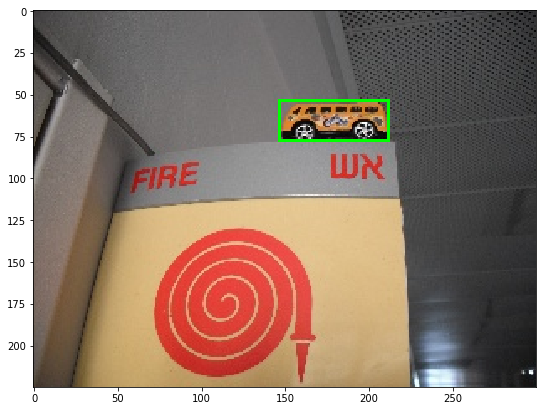

In [10]:
imshow_bbox(images, bboxes, 1)

In [11]:
sometimes = lambda aug: iaa.Sometimes(0.8, aug)
def empty_seq():
    seq = iaa.Sequential()
    seq_det = seq.to_deterministic()
    return seq_det

def seq_det_aug():
    seq = iaa.Sequential([iaa.Multiply(mul=(0.75, 1.25)),
                    iaa.Add(value=(-25,25)),
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.OneOf([
                    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
                    iaa.AdditiveGaussianNoise(scale=(0, 0.02*255))]),
                    sometimes(iaa.Affine(
                            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                            rotate=(-45, 45), # rotate by -45 to +45 degrees
                            shear=(-16, 16), # shear by -16 to +16 degrees
                            order=3, # use nearest neighbour or bilinear interpolation (fast)
                            cval=0, # if mode is constant, use cval 0
                        ))])
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    return seq_det

/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


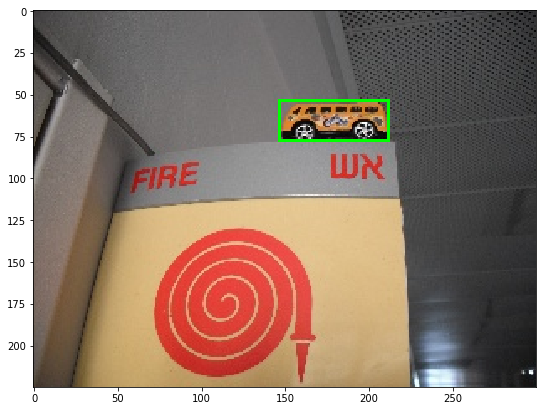

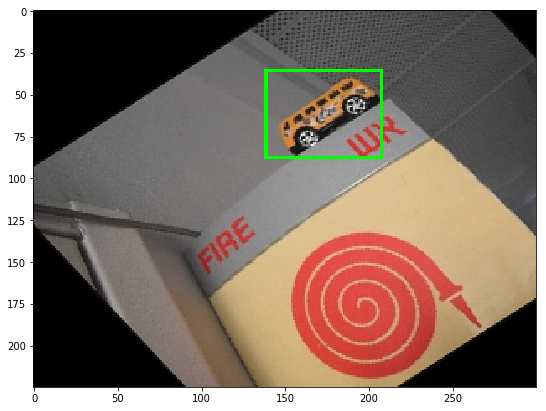

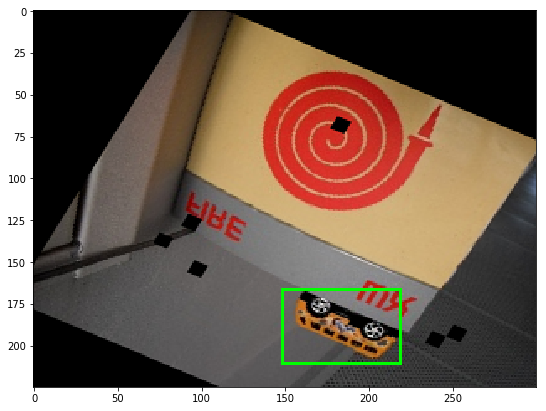

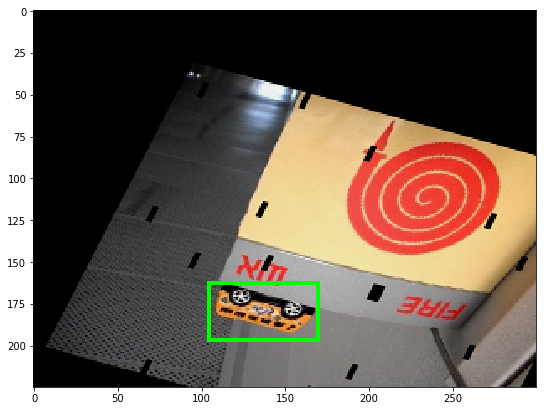

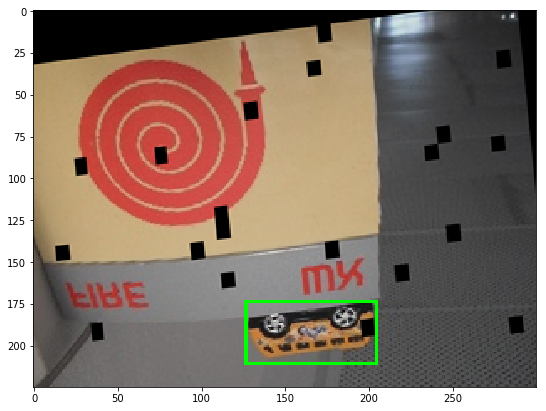

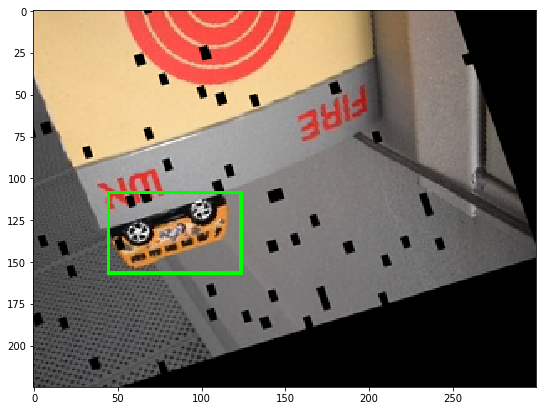

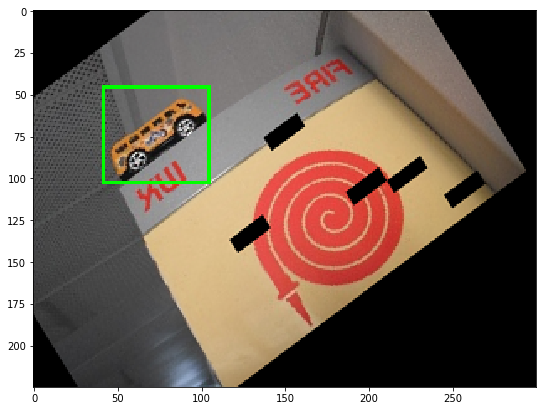

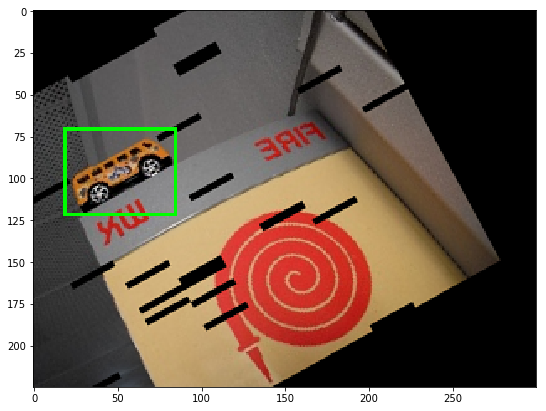

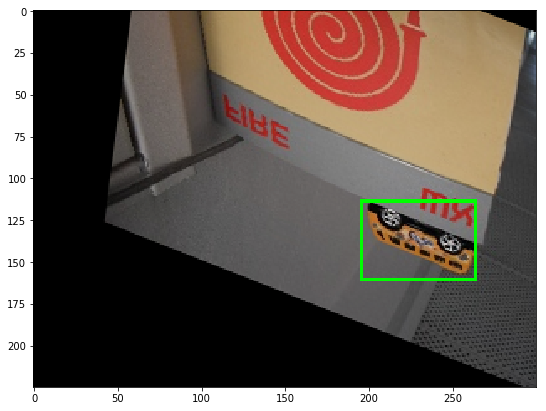

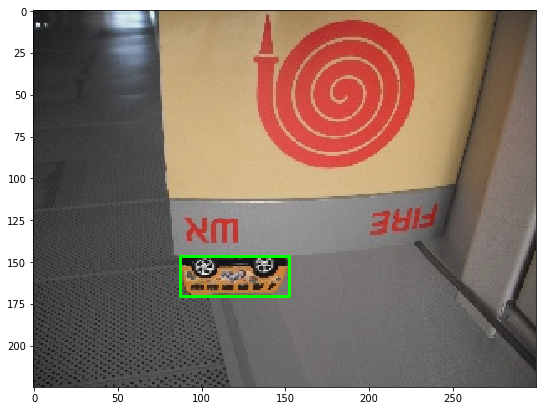

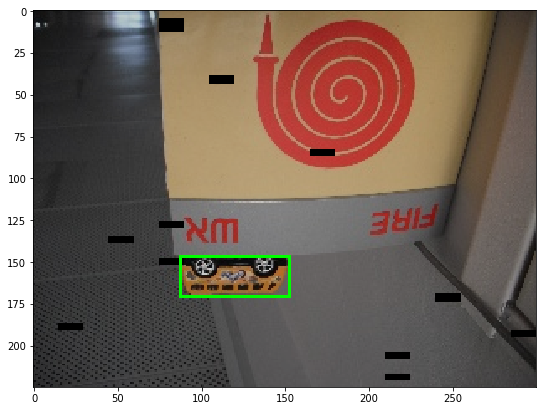

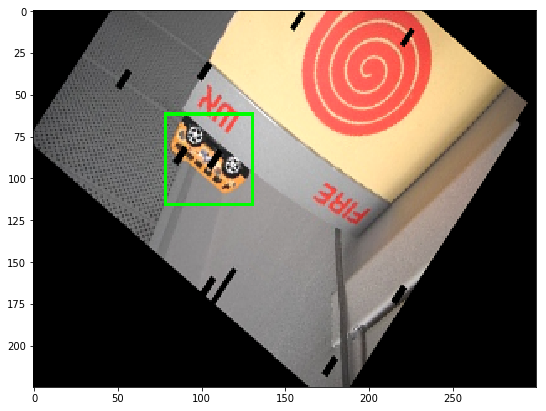

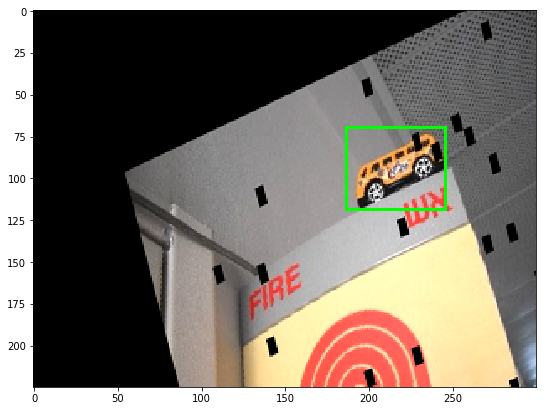

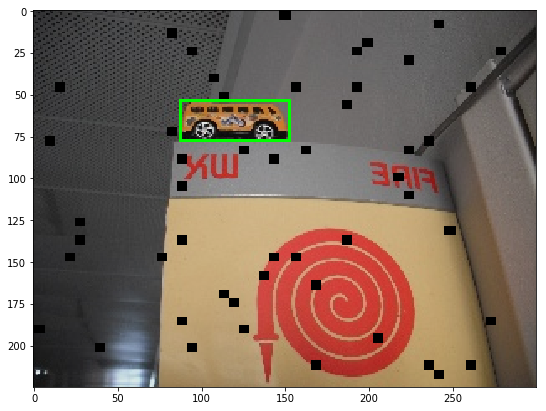

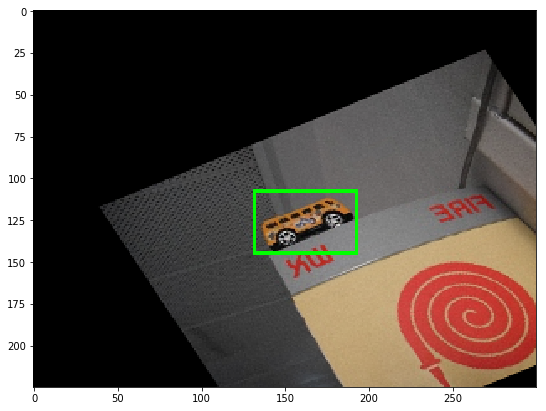

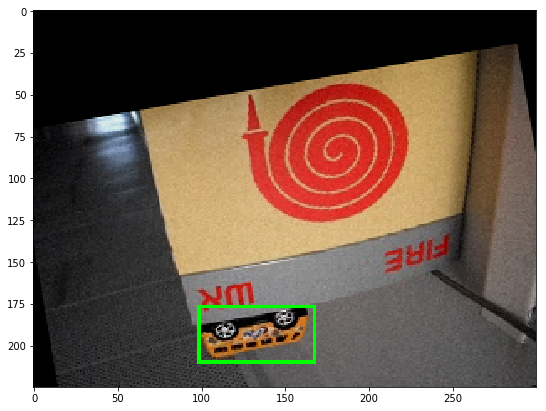

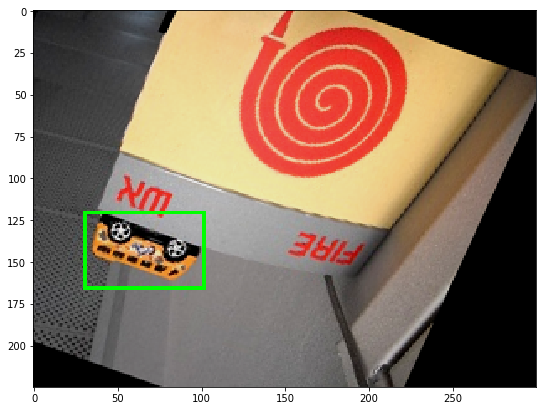

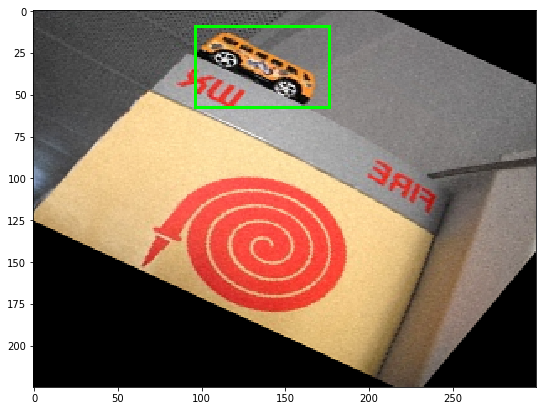

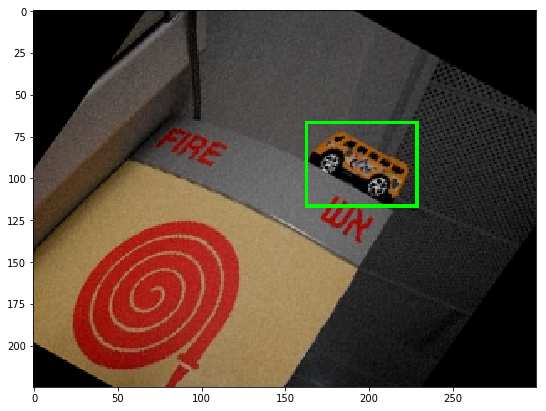

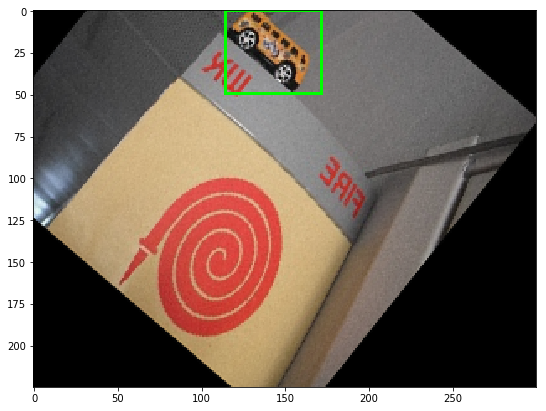

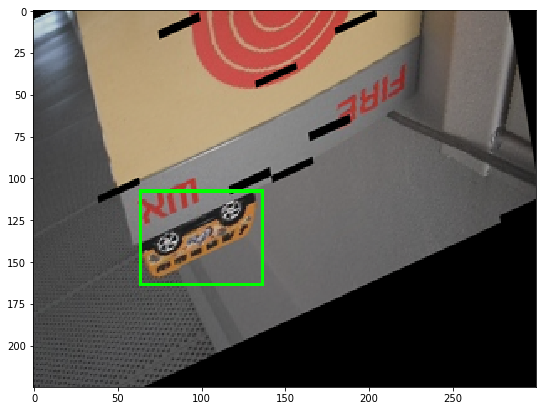

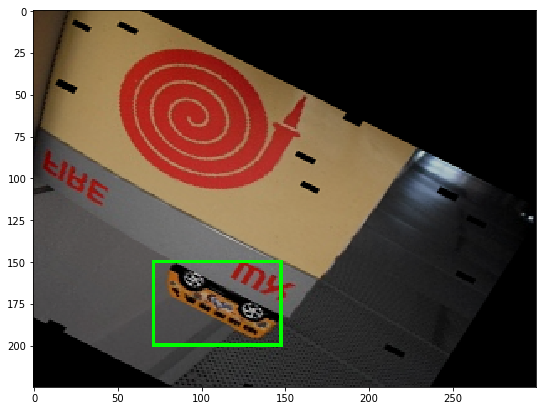

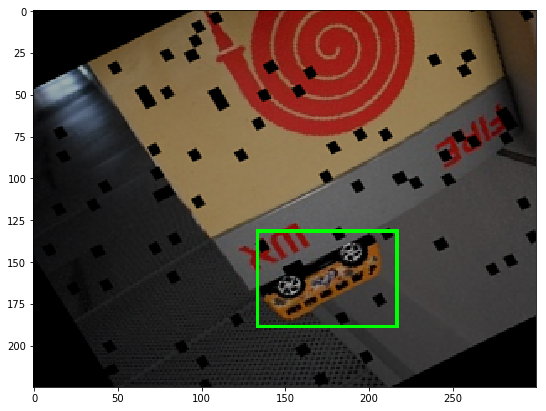

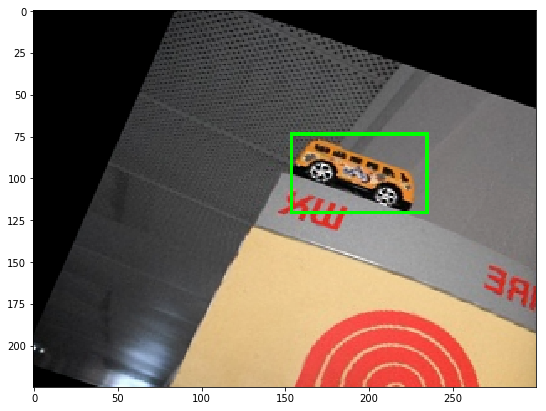

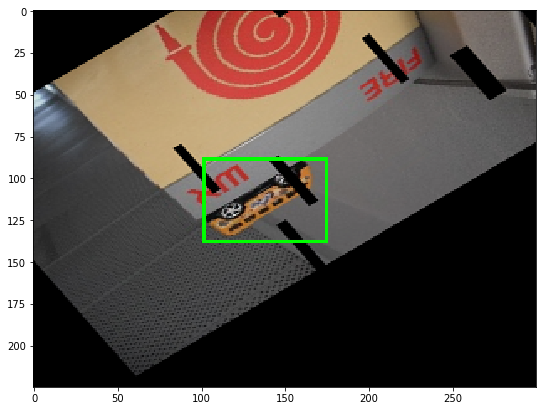

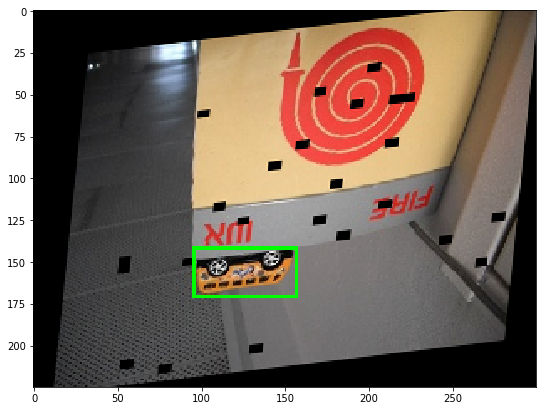

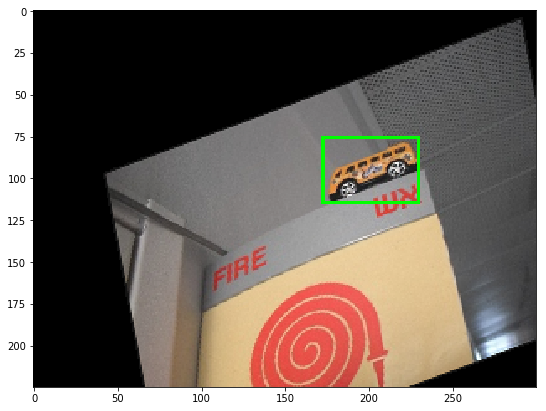

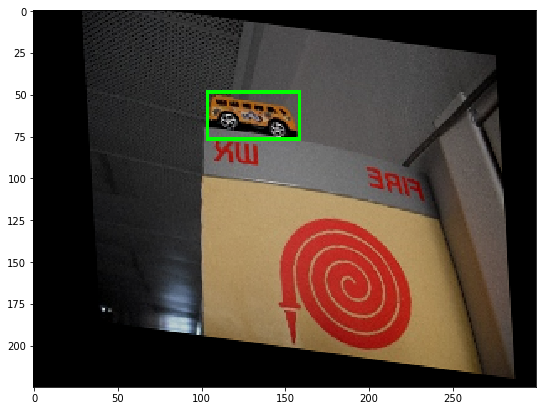

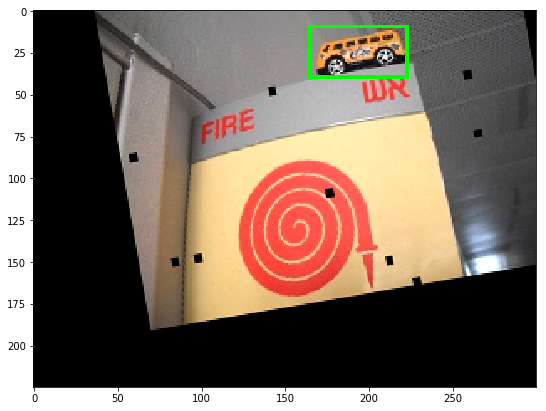

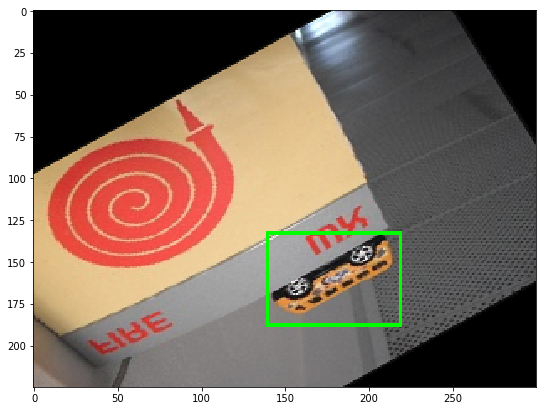

In [12]:
batches_to_concat = []
batch = 30
for i in range(batch):
    if (i == 0):
        seq = empty_seq()
    else:
        seq = seq_det_aug()
        
    images_aug = seq.augment_images(images)
    bboxes_aug = seq.augment_bounding_boxes(bboxes)
    filename_aug_batch = [str(i) + '_' + f for f in filenames_s]
    df_batch = imwrite_aug_ssd(images_aug, filename_aug_batch, bboxes_aug, PATH_TO_AUG_IMAGES)
    batches_to_concat.append(df_batch.copy())
    imshow_bbox(images_aug, bboxes_aug, 1)

df_aug = pd.concat(batches_to_concat)
df_aug.to_csv(os.path.join(PATH_TO_ANNO, 'aug_train_labels.csv'), index=None)

In [13]:
print('Num of objects in the training set:', len(df_aug['filename']))
print('Num of images in the training set:', len(list(set(df_aug['filename'].tolist()))))

Num of objects in the training set: 2820
Num of images in the training set: 1620


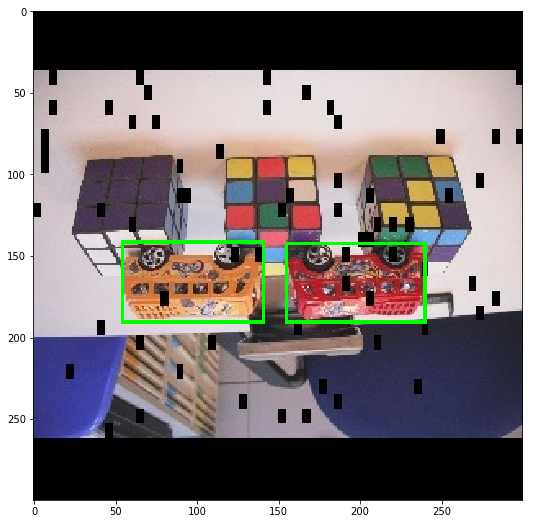

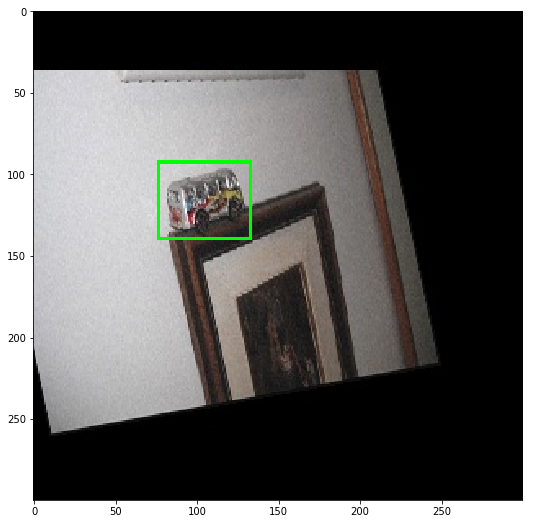

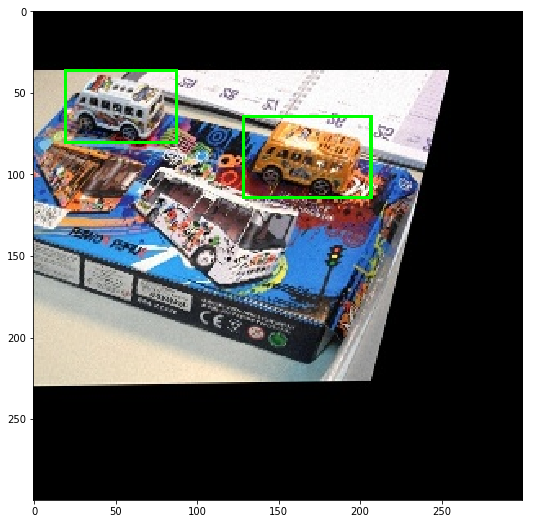

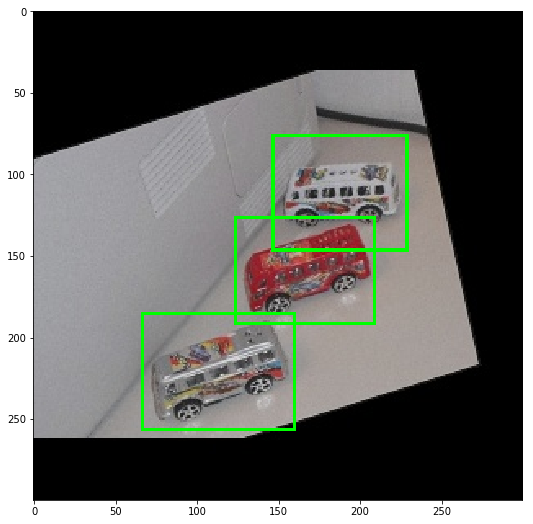

In [14]:
[_, img_t, bb_t] = get_images_bboxes(df=df_aug, path_to_images=PATH_TO_AUG_IMAGES)
imshow_bbox(img_t, bb_t, 4)